# Embedding sparse vectors into lower-dimensional dense space

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/notebooks/catvar-embeddings-homebrew.ipynb)

One-hot vectors are simple but the vocabulary size can make word vectors extremely long; high dimensionality. And they are very sparse, mostly zeros.

Word embeddings, on the other hand, embed that massive dimensional space into a smaller, dense space. For example, [GloVE](https://nlp.stanford.edu/projects/glove/) has pre-trained word embeddings of various sizes such as 50 and 300 dimensions. Unlike word vectors, we need to do some training to compute embeddings. I've used pre-trained word-to-embedding dictionaries to good effect, but we can also train and embedding specific to our task as part of our model, using an embedding layer.

In this notebook, I'm going to explore creating dense vectors for categorical variables by manually concatenating one hot vectors for movie and user IDs using a standard pipeline neural network. After this, I will try separate layers for each categorical variable and then merge them into a pipeline.

## Setup (for use with AWS)

Make sure to enable this to see progress bars:

```
$ conda install nodejs
$ jupyter nbextension enable --py widgetsnbextension
$ jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```
pip install -U tensorflow
pip install tqdm
pip install tensorflow_addons
```

Start on AWS:

```
jupyter lab --no-browser --port=8888
```

Port tunneling to access jupyter on AWS from mac:

```
ssh -i ~/Dropbox/licenses/parrt.pem -L 8000:localhost:8888 ubuntu@54.151.101.201
```

Go to [http://localhost:8000?token=1d8158157...](http://localhost:8000) in mac browser

## Load movie/user/rating data

The [fastai book chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) has an example using user-movie-ratings from [MovieLens](https://grouplens.org/datasets/movielens/) and [Kaggle](https://www.kaggle.com/colinmorris/embedding-layers#Building-a-rating-prediction-model-in-Keras) hasA discussion of how to create embeddings for that data.  I will grab [a small subset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) and put into `data` subdir:

```
data/ml-latest-small
├── README.txt
├── links.csv
├── movies.csv
├── ratings.csv
└── tags.csv
```

"*Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).*" The `ratings.csv` file looks like:

```
userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
...
```

And, in case we are curious, `movies.csv` has:

```
movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
...
```

In [228]:
import pandas as pd
import numpy as np
import re
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

df = load(n=20_000)
df.head(5)

,userId,movieId,rating,title,genres
0,448,97304,4.0,Argo,Drama|Thriller
1,610,97304,4.0,Argo,Drama|Thriller
2,378,97304,3.5,Argo,Drama|Thriller
3,537,97304,4.5,Argo,Drama|Thriller
4,522,97304,2.5,Argo,Drama|Thriller


Let's limit to just comedies and dramas that should be very different semantically

In [229]:
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
print(len(df), 'movies that are Comedy or Drama')

2721 movies that are Comedy or Drama


Rather than deal with arbitrarily large integers representing the various IDs, let's compress that down to unique but adjacent integers. This is also how I would handle string to integer encoding. That function compresses one column at a time and modifies the data frame in place. Compare the movie IDs with the values above. We convert `[3696,  281,  592, 1293, 4446]` to `[4, 1, 2, 3, 5]`:

In [230]:
def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes + 1 # encode 1..n
    
compress_cats(df, 'movieId')
compress_cats(df, 'userId')
df.head(3)

,userId,movieId,rating,title,genres
102,326,100,3.0,Multiplicity,Comedy
103,286,100,3.0,Multiplicity,Comedy
104,309,100,2.0,Multiplicity,Comedy


In [231]:
len(np.unique(df['movieId'])), max(df['movieId'])

(931, 931)

In [232]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()
print(df_movies.shape)
df_movies.head(3)

(931, 3)


,movieId,title,genres
12779,1,Father of the Bride Part II,Comedy
19244,2,Nixon,Drama
9478,3,Four Rooms,Comedy


## RF baseline using labeling coded movie/user IDs

 A random forest is easily able to capture the structure in the training data, but not in a general way. The out of bag and validation R^2 scores are terrible, barely better than just guessing the average.

In [233]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_baseline(df):
    X = df[['movieId','userId']]
    y = df['rating']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    scores = cross_val_score(rf, X, y, cv=5)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X, y):.3f}")
    print(f"Valid R^2 {np.mean(scores):.3f}")

RF_baseline(df)

OOB R^2 -0.030
Train R^2 0.857
Valid R^2 -0.087


## Getting movie ID dense vectors (embeddings)

Ok, Let's try to map both the movie and the user to a rating.

In [234]:
n = len(df)
nusers = len(df.groupby('userId').count())
nmovies = len(df.groupby('movieId').count())
n, nusers, nmovies

(2721, 434, 931)

The input to the neural network will be one hot encoded movie and user identifiers. The output will also be one hot encoded user IDs, but keras will handle that part for us (we can leave y as a list of integer user IDs)

In [235]:
X_onehot = pd.concat([pd.get_dummies(df['movieId']),
                      pd.get_dummies(df['userId'])], axis=1)
y = df['rating'] #pd.get_dummies(df['userId'])
X_onehot.shape, y.shape

((2721, 1365), (2721,))

In [236]:
X_onehot.head(3)

,1,2,3,4,5,6,7,8,9,10,...,425,426,427,428,429,430,431,432,433,434
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [237]:
y.values[0:10]

array([3. , 3. , 2. , 3. , 2. , 1. , 2.5, 3. , 3.5, 3. ])

### Training a simple pipeline network

We are trying to map a sparse movie and user ID vector to a dense vector of say `dimensionality`=8, 10, or 20 dimensions. To do that, we use the first layer of a network that has `dimensionality` neurons. Each neuron will contribute a single dimension to each dense vector. The input X has, say, 10,000 rows, one for each one hot movie ID. It has nmovies columns. If there are 10 movies, there are 10 possible positions in the one hot encoding. The first layer is a transformation from nmovies+nusers space to `dimensionality` space. The key is that we want to choke that first layer into just a few neurons and then have a big layer afterwards that tries to make sense of those new compressed features. We don't care about the prediction at the end, we are just going to take the weights out of the first layer to get the embeddings.

In [240]:
from tensorflow.keras import models, layers, callbacks, optimizers
import tensorflow_addons as tfa
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

def train(df,
          dimensionality = 8,
          otherlayers = (100,),
          batch_size = 10,
          epochs = 20,
          batchnorm = False,
          dropout = 0):
    # Everybody get one hot!
    nusers = len(df.groupby('userId').count())
    nmovies = len(df.groupby('movieId').count())
    X_onehot = pd.concat([pd.get_dummies(df['movieId']),
                          pd.get_dummies(df['userId'])], axis=1)
    y = df['rating']

    layer1 = dimensionality
    model = models.Sequential()
    model.add(layers.Dense(layer1, input_dim=nmovies+nusers, activation='relu',
                           name='embedding'))
    for n_hidden in otherlayers:
        model.add(layers.Dense(n_hidden, activation='relu'))
        if batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout))

    model.add(layers.Dense(1))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.RMSprop(),
                  metrics=['mae'])
    #print(model.summary())

    history = model.fit(X_onehot, y,
                        shuffle=True,
                        epochs=epochs,
                        validation_split=0.15,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                        )
    return model, history

In [241]:
model, history = train(df)

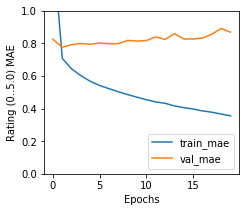

In [74]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(3.5,3))
    plt.ylabel("Rating (0..5.0) MAE")
    plt.xlabel("Epochs")
    accur = history.history['mae']
    plt.plot(accur, label='train_mae')
    val_accur = history.history['val_mae']
    plt.plot(val_accur, label='val_mae')
    # plt.xlim(0, 200)
    plt.ylim(0.0, 1.00)
    plt.legend(loc='lower right')
    plt.show()
    
plot_history(history)

Validation error is not good (.8 stars off out of 5), but [Oliver](http://www.zeigermann.eu/) says we care about training error for getting embeddings since we won't be using the predictions.  In his example, he only has about 10% accuracy so I'm going to consider this accuracy pretty good.

### Getting the embeddings out of the network


[Here](https://djcordhose.github.io/ml-workshop/2019-embeddings.html#/17), Oliver explains how to get the embeddings out. These are the outputs from the first constrained layer. I'm going to simply ask for the weights and the biases then manually get the embedding vectors, rather than create a model just to get the output transformation:

In [14]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
w.shape, b.shape

((1376, 8), (8,))

First, let's take a look at the shape of the matrix. The shape of the weight matrix is the transpose of what I would expect. For example, I like the convention of a row being the weights of a single neuron. Since I have `dimensionality` neurons, I would expect `dimensionality` rows, but still we can just reverse the operands of the dot product. We have a complication here in that the movie and user IDs were concatenated together. For example, we created one hot vectors for the movie and user IDs of each record.  Here is the code again and the shape of one record, `x`, from `X`:

In [15]:
X = pd.concat([pd.get_dummies(df['movieId']),
               pd.get_dummies(df['userId'])], axis=1)
x = X.iloc[99] # Grab some random record
x.shape

(1376,)

The following gives us the output of the embedding layer using the standard matrix notation for what a dense layer computes (without the ReLu activation function):

In [16]:
np.dot(w.T,x) + b  # flip w so it is neurons x input dims (as I'm used to)
np.dot(x,w) + b 

array([0.24, 0.13, 0.13, 0.05, 0.12, 0.08, 0.08, 0.19], dtype=float32)

**Note**: The dot product is really just selecting the ith and jth row of w for one-hot turned on at positions i and j (for movie and user).  A row in w (in keras) is the set of weights across neurons for a particular feature, a (compressed) movie&user ID in our case. That gives us a vector in `dimensionality`-space where each dimension is some semantic meaning we got from a neuron. Because two of the input columns for a record will be turned on, that means the dot product is selecting two rows and adding them together. We should get the same answer by doing pulling the vectors out and adding the bias manually, which will be much faster:

In [17]:
# Where are the one hots on?  It reminds me I need to add nmovies to get to the second one hot index
np.where(x==1)[0]

array([306, 982])

In [18]:
mi = df.iloc[99]['movieId']
ui = df.iloc[99]['userId']
mi = mi-1
ui = nmovies+ui-1

So the following demonstrates we can get the exact same embedding vector by selecting rows and adding the bias:

In [19]:
w[mi] + w[ui] + b

array([0.24, 0.13, 0.13, 0.05, 0.12, 0.08, 0.08, 0.19], dtype=float32)

If we want just the embedding for a movie we will have to be satisfied with `w[mi]` or perhaps I can try `w[mi]+b`. To get all of the movie embeddings we get the first nmovies rows of the weight matrix:

In [20]:
movie_embeddings = w[0:nmovies]
print(f"For each of {movie_embeddings.shape[0]} movies we have a vector of size {movie_embeddings.shape[1]}")
print(f"Example embedding: {list(movie_embeddings[0])}")

For each of 953 movies we have a vector of size 8
Example embedding: [-0.0071590343, 0.06793967, 0.034765586, -0.08924115, -0.004593617, -0.10015657, 0.019363439, 2.7677015e-05]


## PCA projection of comedy and drama

In [21]:
from sklearn.decomposition import PCA

def plot_embeddings(df_movies, movie_embeddings, xrange=(-.3,.3), yrange=(-.15,.15)):
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [('k' if 'Comedy' in genres[i] else 'r') for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()

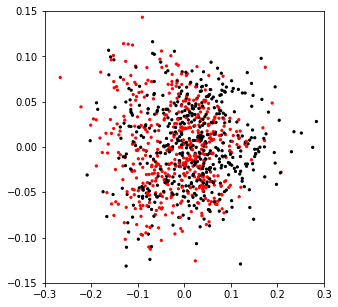

In [22]:
plot_embeddings(df_movies, movie_embeddings)

It doesn't look super separated, but the red comedy dots are perhaps shifted to the left.

## RF accuracy with embeddings

In [23]:
def RF_onehot(df, movie_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']-1],movie_embeddings[X['userId']-1]], axis=1)
#     X_train, X_test, y_train, y_test = train_test_split(X_emb, y, test_size=0.2)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    scores = cross_val_score(rf, X_emb, y, cv=5)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")
    print(f"5-fold valid R^2 {np.mean(scores):.3f}")

RF_onehot(df, movie_embeddings)

OOB R^2 0.252
Train R^2 0.896
5-fold valid R^2 0.277


Heh, Cool! The validation accuracy (R^2) has gone from guessing to something much better than random guessing.

## The effect of training on embeddings

### Small sample

Interesting. A sample of size 5000 gets about the same validation error using a random forest and these embeddings.

In [24]:
df = load(n=5_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')

In [25]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

In [26]:
RF_baseline(df)

OOB R^2 -0.030
Train R^2 0.858
Valid R^2 -0.067


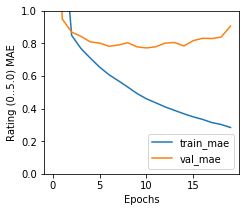

In [27]:
model, history = train(df)
plot_history(history)

In [28]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
movie_embeddings = w[0:nmovies]

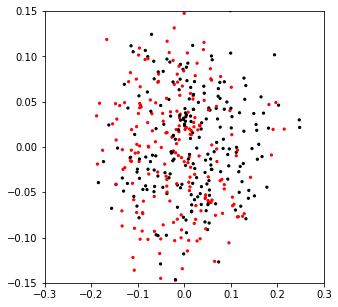

In [29]:
plot_embeddings(df_movies, movie_embeddings)

In [30]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
movie_embeddings = w[0:nmovies]

In [31]:
RF_onehot(df, movie_embeddings)

OOB R^2 0.262
Train R^2 0.896
5-fold valid R^2 0.303


Weird, are these a little bit better than the 20k record sample?

### Big sample

Interesting. Most of the data (100,000) gets about the same validation error using a random forest and these embeddings as the other samples but the PCA looks more separated.

In [404]:
df = load(n=100_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')

In [405]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

In [34]:
RF_baseline(df)

OOB R^2 0.049
Train R^2 0.868
Valid R^2 -0.064


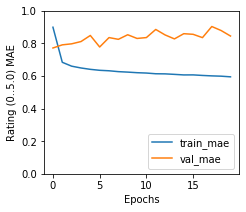

In [406]:
model, history = train(df)
plot_history(history)

In [407]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
movie_embeddings = w[0:nmovies]

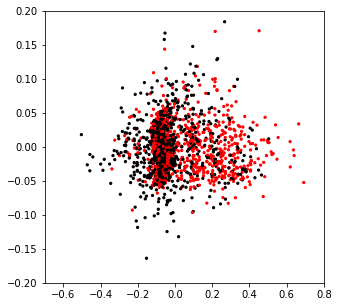

In [408]:
plot_embeddings(df_movies, movie_embeddings, xrange=(-.7,.8), yrange=(-.2,.2))

Now that is starting to separate!

In [409]:
RF_onehot(df, movie_embeddings)

OOB R^2 0.287
Train R^2 0.902
5-fold valid R^2 0.249


### Add bias to movie encoding

Previously we did not add the bias to the weight matrix. Let's go back to 20,000 records and see what happens if we had the bias.

In [39]:
df = load(n=20_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')

In [40]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

In [41]:
RF_baseline(df)

OOB R^2 -0.036
Train R^2 0.857
Valid R^2 -0.119


In [42]:
model, history = train(df)

In [59]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
movie_embeddings = w[0:nmovies] + b  # <------------- Here is the only difference this section (add bias)

In [60]:
RF_onehot(df, movie_embeddings)

OOB R^2 0.275
Train R^2 0.901
5-fold valid R^2 0.268


The bias does not seem to make any difference at all, at least for this network model where I concatenated the movie and user IDs. Come to think of it, why would adding a bias change anything because we are adding the same bias to every embedding. Certainly it would affect the layers downstream in the network during training and for prediction, but I'm not sure we need to add the bias to get the embeddings.

### Increase embedding dimensionality

We used dimensionality of 8 earlier, so let's try bumping that up. Bumped it up to 64 and it didn't seem to change much.

In [46]:
df = load(n=20_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')

In [47]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

In [48]:
RF_baseline(df)

OOB R^2 0.024
Train R^2 0.865
Valid R^2 -0.048


In [67]:
model, history = train(df, dimensionality=16)

In [68]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
movie_embeddings = w[0:nmovies]

In [73]:
# These numbers seem to bounce around a lot due to cross validation selections
RF_onehot(df, movie_embeddings)

OOB R^2 0.274
Train R^2 0.899
5-fold valid R^2 0.280


### Play with training and validation accuracy from network itself

Training MAE only gets down to about 0.4 an validation error at 20 epochs is about 1.0, so let's try to improve that and see what effect it has.

* Going to 50 epochs did not change much
* Going to 1000 in the second layer, 50 epochs: dropped accuracy in half for 5-fold cross validation
* 20 epochs, 100 in second layer, with batch normalization: dropped accuracy
* 20 epochs, 100 in second layer, without batch normalization and dropout of 0.2 - 0.5: no significant change (adding batch normalization seems to hurt it at 0.3 drop out)
* Increasing the number of epochs hurts validation score, improves training score and hurts the RF validation score using the embeddings; maybe validation score matters?
* Above 50ish, the batch size starts to hurt RF validation scores
* Interesting. Dropping from 100 to 32 and the hidden layer seems to slightly improve the score
* Adding 32 and 4-sized layers after the embedding layer improves things so we are at about .3 MAE with the random forest validation; PCA looks to be separating more. Cranking up the number of epochs, starts to hurt the validation score badly and the random forest validation. 20 seems to be the right number of epochs
* otherlayers=(32,4,4) seems to give a slight improvement
* Wow. dimensionality=4 works well too with otherlayers=(32,4,4) and epochs=20

In [79]:
df = load(n=20_000)
df = df[(df['genres']=='Comedy')|(df['genres']=='Drama')]
nmovies = len(df.groupby('movieId').count())
compress_cats(df, 'movieId')
compress_cats(df, 'userId')

In [80]:
# get unique movie ID and title and genres
df_movies = df.sort_values('movieId')[['movieId','title','genres']]
df_movies = df_movies.drop_duplicates()

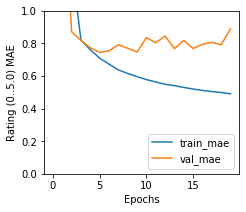

In [387]:
model, history = train(df, epochs=20, dimensionality=8,
                       otherlayers=(32,4,4),
                       batchnorm=False, dropout=0.0, batch_size=30)
plot_history(history)

In [388]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
movie_embeddings = w[0:nmovies]

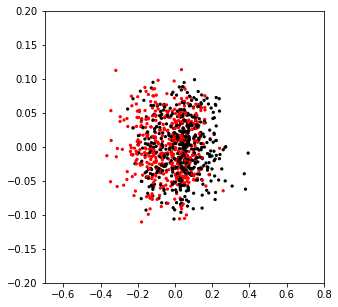

In [389]:
plot_embeddings(df_movies, movie_embeddings, xrange=(-.7,.8), yrange=(-.2,.2))

In [390]:
RF_onehot(df, movie_embeddings)

OOB R^2 0.302
Train R^2 0.904
5-fold valid R^2 0.303


## t-SNE (t-distributed stochastic neighbor embedding)

In [402]:
# Useful code derived from Shikhar Gupta's great discussion at
# https://towardsdatascience.com/collaborative-filtering-and-embeddings-part-2-919da17ecefb

from sklearn.manifold import TSNE

def plot_embeddings_tSNE(df_movies, movie_embeddings):
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=10)
    tsne_results = tsne.fit_transform(movie_embeddings)
    plot_x = tsne_results[:,0]
    plot_y = tsne_results[:,1]
    c = [('k' if 'Comedy' in genres[i] else 'r') for i in range(len(tsne_results))]
    plt.scatter(plot_x, plot_y, c=c, s=5)
    plt.show()    

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1986 samples in 0.001s...
[t-SNE] Computed neighbors for 1986 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1986
[t-SNE] Computed conditional probabilities for sample 1986 / 1986
[t-SNE] Mean sigma: 0.032011
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.836372
[t-SNE] KL divergence after 1000 iterations: 1.725135


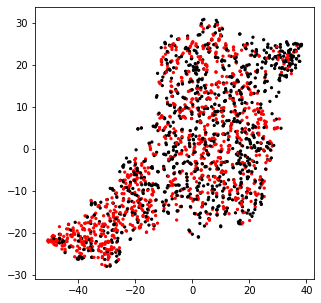

In [410]:
plot_embeddings_tSNE(df_movies, movie_embeddings)